In [1]:
import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from collections import deque

%matplotlib inline

In [2]:
env = gym.make('CartPole-v0')
env.seed(0)

# Properties of the environment
# vector of 4
state_space = env.observation_space

print('Low: ', state_space.low)
print('High: ', state_space.high)

# vector of 2
action_space = env.action_space

print('States: ', state_space)
print('Actions: ', action_space)

state_size = state_space.shape[0]
action_size = action_space.n
print('State vector size: ', state_size)
print('Actions vector size: ', action_size)

class SimplePolicy():
    def __init__(self, env, state_size, action_size, gamma):
        np.random.seed(0)
        
        self.env = env
        self.gamma = gamma
        
        self.state_size = state_size
        self.action_size = action_size
        
        # Note: More efficient to use 1D array (1 is added for the bias)
        self.w = 1e-4 * np.random.rand(state_size, action_size)
        
        # Note: Used in order to decide on the adaptive random radius (adaptive scale hill climbing algorithm)
        self.last_reward = -np.Inf
        self.best_w = self.w
        
        self.up_fraction = 2
        self.down_fraction = 0.5
        
    def forward(self, state):
        return np.argmax(self.softmax(self.w.T.dot(state)))
    
    def softmax(self, x):
        return np.exp(x) / sum(np.exp(x))
    
    # Note: Perturb with adaptive Gaussian noise
    def update(self, reward, sigma):
        if reward < self.last_reward:
            sigma = min(2, sigma * self.up_fraction)
            self.w = self.best_w + sigma * np.random.rand(self.state_size, self.action_size)
        else:
            # Note: We risk vanishing "gradients"
            sigma = max(1e-3, sigma * self.down_fraction)
            self.w += sigma * np.random.rand(self.state_size, self.action_size)
            
            self.best_w = self.w
            self.last_reward = reward
        
        return sigma
        
gamma = 0.9

Low:  [-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]
High:  [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
States:  Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
Actions:  Discrete(2)
State vector size:  4
Actions vector size:  2


In [3]:
def run(env, policy, nepisodes):
    average_scores = deque(maxlen=100)
    sigma = 0.1
    
    scores = []
    
    for episode_idx in range(1, nepisodes + 1):
        state = env.reset()
        
        episode_rewards = []
        while True:
            action = policy.forward(state)
            
            next_state, reward, done, _ = env.step(action)
            
            episode_rewards.append(reward)
            
            # Note: Update at every run and not at each episode
            # Rt+1 = SUM(from k=0 -> inf)[ (gamma**k) * Rt+k+1 ]
            cummulative_reward = np.sum([ (gamma**idx) * episode_rewards[idx] for idx in range(0, len(episode_rewards)) ])

            sigma = policy.update(cummulative_reward, sigma)
            
            state = next_state
            
            if done:
                break
        
        # Note: I might update here
        
        scores.append(sum(episode_rewards))
        average_scores.append(sum(episode_rewards))
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode_idx, np.mean(average_scores)), end='')
        
        if np.mean(average_scores) >= 195.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(max(1, episode_idx - 100), np.mean(average_scores)))
            break
            
    return scores

policy = SimplePolicy(env, state_size, action_size, gamma)
scores = run(env, policy, 2000)

Episode 1	Average Score: 200.00
Environment solved in 1 episodes!	Average Score: 200.00


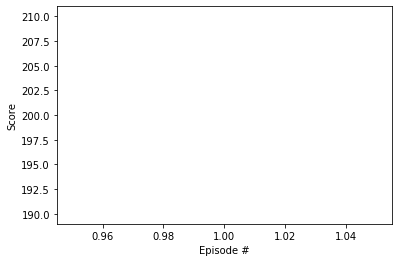

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores) + 1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [5]:
# load the weights from file
state = env.reset()
while True:
    with torch.no_grad():
        action = policy.forward(state)
    env.render()
    next_state, reward, done, _ = env.step(action)
    state = next_state
    if done:
        break

env.close()

In [6]:
'''
Notes:

I have been updating at every episode run, thus, the weights are updated way faster. But they seem unstable this way, even though sometimes, the task is solved in 1 episode.
It seems like it is very dependent on the initialization of the weights.
It seems also that the sigma does not influence that much the episodes in which the policy is learnt, or converged, as long as it is greater than 0.1.

Perhaps a better approach, as in the udacity example, is to do it after each run, once per iteration. I have seen, after revision, that their learning is more stable.
'''

'\nNotes:\n\nI have been updating at every episode run, thus, the weights are updated way faster. But they seem unstable this way, even though sometimes, the task is solved in 1 episode.\nIt seems like it is very dependent on the initialization of the weights.\nIt seems also that the sigma does not influence that much the episodes in which the policy is learnt, or converged, as long as it is greater than 0.1.\n\nPerhaps a better approach, as in the udacity example, is to do it after each run, once per iteration. I have seen, after revision, that their learning is more stable.\n'